In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import numpy as np
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [ ]:
# --- 1. CARREGAR O MODELO 1K E RECRIAR O CONJUNTO DE TESTE ---
model_path = "/Users/giossaurus/Developer/leia_tcc/models/leia_classifier_1k_final"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

path_seed_set = '/Users/giossaurus/Developer/leia_tcc/data/processed/seed_set_anotado.csv'
path_cycle1 = '/Users/giossaurus/Developer/leia_tcc/data/processed/active_learning_cycle1.csv'
path_cycle2 = '/Users/giossaurus/Developer/leia_tcc/data/processed/active_learning_cycle2.csv'
path_lote_final = '/Users/giossaurus/Developer/leia_tcc/data/processed/anotacao_maior_final.csv'

def process_dataframe(df, name):
    all_data = []
    text_cols = ['question', 'text']
    label_cols = ['intent_choice', 'label']

    text_col = None
    for col in text_cols:
        if col in df.columns:
            text_col = col
            break

    label_col = None
    for col in label_cols:
        if col in df.columns:
            label_col = col
            break

    if not text_col or not label_col:
        print(f"  - ERRO em {name}: Colunas essenciais n√£o encontradas")
        return all_data

    for i in range(len(df)):
        try:
            text_val = df.iloc[i][text_col]
            label_val = df.iloc[i][label_col]
            question_id = df.iloc[i].get('question_id', f"{name}_{i}")

            if pd.notna(text_val) and pd.notna(label_val) and str(text_val).strip() and str(label_val).strip():
                all_data.append({
                    'text': str(text_val).strip(),
                    'label': str(label_val).strip(),
                    'question_id': str(question_id) if pd.notna(question_id) else f"{name}_{i}",
                    'source': name
                })
        except Exception as e:
            continue

    return all_data

# Carregar e processar todos os arquivos
all_data = []
for path, name in [(path_seed_set, "Seed set"), (path_cycle1, "Cycle1"),
                   (path_cycle2, "Cycle2"), (path_lote_final, "Lote final")]:
    try:
        df = pd.read_csv(path)
        data = process_dataframe(df, name)
        all_data.extend(data)
        print(f"{name}: {len(data)} exemplos")
    except Exception as e:
        print(f"Erro ao carregar {name}: {e}")

# Criar dataframe consolidado
df_full_manual = pd.DataFrame(all_data)
df_final_clean = df_full_manual[['text', 'label']].copy()

# Remover duplicatas por question_id
if 'question_id' in df_full_manual.columns:
    df_full_manual = df_full_manual.drop_duplicates(subset=['question_id'])

# Mapear r√≥tulos para IDs (mesmo mapeamento do notebook 18)
labels = df_final_clean['label'].unique().tolist()
id2label_data = {i: label for i, label in enumerate(labels)}
label2id_data = {label: i for i, label in enumerate(labels)}

print(f"Labels encontrados: {labels}")
print(f"Mapeamento dos dados: {label2id_data}")

# Aplicar mapeamento
df_final_clean['label'] = df_final_clean['label'].map(label2id_data)
df_final_clean.dropna(subset=['label'], inplace=True)
df_final_clean['label'] = df_final_clean['label'].astype(int)

# Criar o dataset e fazer o mesmo split que foi usado no notebook 18
from datasets import ClassLabel
full_dataset = Dataset.from_pandas(df_final_clean)
features = full_dataset.features.copy()
features['label'] = ClassLabel(names=labels)
full_dataset = full_dataset.cast(features)

# MESMO SPLIT QUE FOI USADO NO NOTEBOOK 18 (seed=42)
dataset_split = full_dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_dataset_full = dataset_split["train"]
test_dataset = dataset_split["test"]

# Usar o conjunto de teste que foi separado
df_final_test = test_dataset.to_pandas()
final_test_dataset = test_dataset

# Mapear labels do modelo
id2label = model.config.id2label
label2id = model.config.label2id
print(f"Labels do modelo: {id2label}")
print(f"Labels dos dados: {id2label_data}")

# Verificar se os mapeamentos coincidem
if set(id2label.values()) != set(id2label_data.values()):
    print("AVISO: Mapeamentos de labels diferentes entre modelo e dados!")
    print("Tentando ajustar...")
    # Remapear se necess√°rio - mapear pelos nomes das classes
    final_label_mapping = {}
    for data_id, data_label in id2label_data.items():
        for model_id, model_label in id2label.items():
            if data_label == model_label:
                final_label_mapping[data_id] = model_id
                break

    if len(final_label_mapping) == len(labels):
        print("Remapeamento bem-sucedido!")
        df_final_test['label'] = df_final_test['label'].map(final_label_mapping)
        final_test_dataset = Dataset.from_pandas(df_final_test)
        # Atualizar para usar as mesmas features
        features_new = final_test_dataset.features.copy()
        features_new['label'] = ClassLabel(names=list(id2label.values()))
        final_test_dataset = final_test_dataset.cast(features_new)
    else:
        print("ERRO: N√£o foi poss√≠vel fazer o remapeamento completo!")
else:
    print("Mapeamentos coincidentes - OK!")

print(f"Modelo carregado de '{model_path}'")
print(f"Conjunto de teste final: {len(final_test_dataset)} exemplos")
print(f"Labels dispon√≠veis: {list(id2label.values())}")
print(f"Distribui√ß√£o do teste: {df_final_test['label'].value_counts().sort_index()}")

Recarregando dados do notebook 18...
Seed set: 200 exemplos
Cycle1: 50 exemplos
Cycle2: 50 exemplos
Lote final: 699 exemplos
Labels encontrados: ['An√°lise de Exemplo', 'Conceitual', 'Procedimental', 'Comparativo']
Mapeamento dos dados: {'An√°lise de Exemplo': 0, 'Conceitual': 1, 'Procedimental': 2, 'Comparativo': 3}


Casting the dataset:   0%|          | 0/999 [00:00<?, ? examples/s]

Labels do modelo: {0: 'An√°lise de Exemplo', 1: 'Conceitual', 2: 'Procedimental', 3: 'Comparativo'}
Labels dos dados: {0: 'An√°lise de Exemplo', 1: 'Conceitual', 2: 'Procedimental', 3: 'Comparativo'}
Mapeamentos coincidentes - OK!
Modelo carregado de '/Users/giossaurus/Developer/leia_tcc/models/leia_classifier_1k_final'
Conjunto de teste final: 200 exemplos
Labels dispon√≠veis: ['An√°lise de Exemplo', 'Conceitual', 'Procedimental', 'Comparativo']
Distribui√ß√£o do teste: label
0    80
1    53
2    55
3    12
Name: count, dtype: int64


In [ ]:
# --- 2. PREPARAR OS DADOS DE TESTE ---
# Tokenizar o conjunto de teste
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_final_test_dataset = final_test_dataset.map(tokenize_function, batched=True)

print("Dados tokenizados com sucesso")

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dados tokenizados com sucesso


In [47]:
# --- 3. EXECUTAR AVALIA√á√ÉO DETALHADA ---
# Carregar as m√©tricas
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_detailed_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    results = {}
    results.update(accuracy_metric.compute(predictions=predictions, references=labels))
    results.update(f1_metric.compute(predictions=predictions, references=labels, average="weighted"))
    results.update(precision_metric.compute(predictions=predictions, references=labels, average="weighted"))
    results.update(recall_metric.compute(predictions=predictions, references=labels, average="weighted"))
    
    # M√©tricas por classe
    f1_per_class = f1_metric.compute(predictions=predictions, references=labels, average=None)
    precision_per_class = precision_metric.compute(predictions=predictions, references=labels, average=None)
    recall_per_class = recall_metric.compute(predictions=predictions, references=labels, average=None)
    
    results['f1_per_class'] = f1_per_class['f1']
    results['precision_per_class'] = precision_per_class['precision']
    results['recall_per_class'] = recall_per_class['recall']
    
    return results

# Criar um Trainer apenas para a avalia√ß√£o
final_trainer = Trainer(
    model=model,
    compute_metrics=compute_detailed_metrics
)

# Fazer as predi√ß√µes e obter as m√©tricas
print("Executando avalia√ß√£o...")
final_evaluation_results = final_trainer.evaluate(eval_dataset=tokenized_final_test_dataset)

print("\n" + "="*60)
print("RESULTADOS FINAIS DO MODELO 1K (CONJUNTO DE TESTE)")
print("="*60)
print(f"Acur√°cia Final: {final_evaluation_results['eval_accuracy']:.4f} ({final_evaluation_results['eval_accuracy']*100:.2f}%)")
print(f"F1-Score Final (Ponderado): {final_evaluation_results['eval_f1']:.4f}")
print(f"Precis√£o Final (Ponderada): {final_evaluation_results['eval_precision']:.4f}")
print(f"Recall Final (Ponderado): {final_evaluation_results['eval_recall']:.4f}")
print("="*60)

Executando avalia√ß√£o...



RESULTADOS FINAIS DO MODELO 1K (CONJUNTO DE TESTE)
Acur√°cia Final: 0.7200 (72.00%)
F1-Score Final (Ponderado): 0.6982
Precis√£o Final (Ponderada): 0.6777
Recall Final (Ponderado): 0.7200


In [48]:
# --- 4. AN√ÅLISE DETALHADA POR CLASSE ---

# Obter predi√ß√µes para an√°lise detalhada
predictions_output = final_trainer.predict(tokenized_final_test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Relat√≥rio de classifica√ß√£o detalhado
print("\nRELAT√ìRIO DE CLASSIFICA√á√ÉO DETALHADO:")
print("-" * 50)
target_names = [id2label[i] for i in sorted(id2label.keys())]
class_report = classification_report(true_labels, predictions, target_names=target_names, digits=4)
print(class_report)

# M√©tricas por classe individuais
print("\nM√âTRICAS POR CLASSE:")
print("-" * 50)
for i, class_name in enumerate(target_names):
    if i < len(final_evaluation_results['eval_f1_per_class']):
        print(f"{class_name:20} | F1: {final_evaluation_results['eval_f1_per_class'][i]:.4f} | "
              f"Precis√£o: {final_evaluation_results['eval_precision_per_class'][i]:.4f} | "
              f"Recall: {final_evaluation_results['eval_recall_per_class'][i]:.4f}")


RELAT√ìRIO DE CLASSIFICA√á√ÉO DETALHADO:
--------------------------------------------------
                    precision    recall  f1-score   support

An√°lise de Exemplo     0.6824    0.7250    0.7030        80
        Conceitual     0.5789    0.6226    0.6000        53
     Procedimental     0.9138    0.9636    0.9381        55
       Comparativo     0.0000    0.0000    0.0000        12

          accuracy                         0.7200       200
         macro avg     0.5438    0.5778    0.5603       200
      weighted avg     0.6777    0.7200    0.6982       200


M√âTRICAS POR CLASSE:
--------------------------------------------------
An√°lise de Exemplo   | F1: 0.7030 | Precis√£o: 0.6824 | Recall: 0.7250
Conceitual           | F1: 0.6000 | Precis√£o: 0.5789 | Recall: 0.6226
Procedimental        | F1: 0.9381 | Precis√£o: 0.9138 | Recall: 0.9636
Comparativo          | F1: 0.0000 | Precis√£o: 0.0000 | Recall: 0.0000


Gr√°fico salvo: matriz_confusao_modelo_1k.png


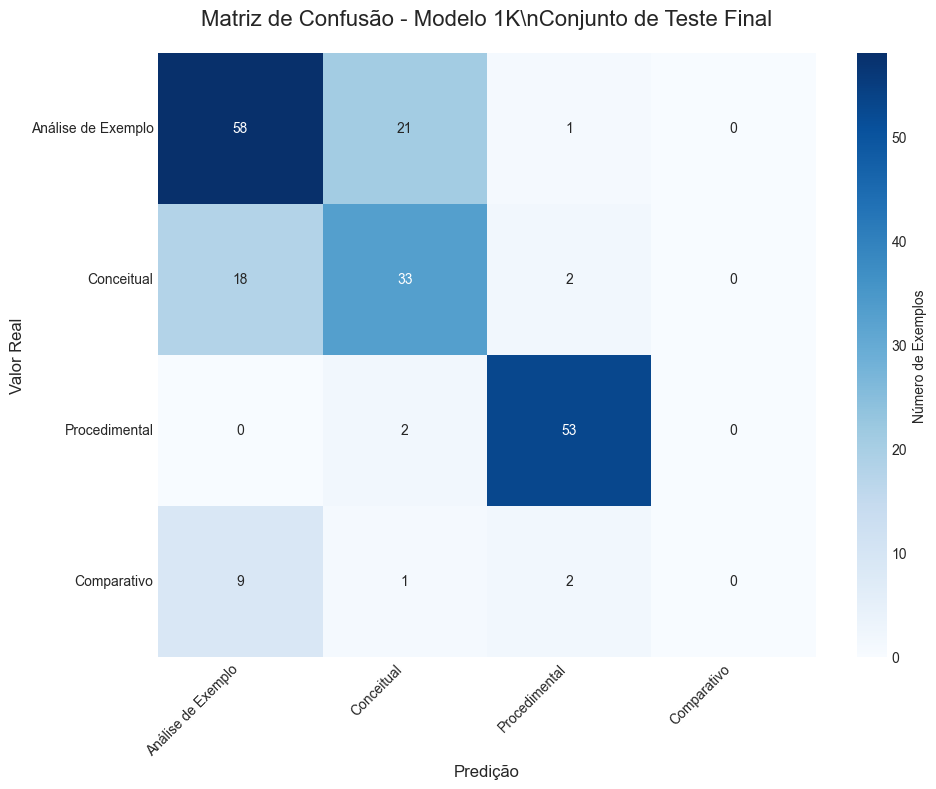

Gr√°fico salvo: matriz_confusao_normalizada_modelo_1k.png


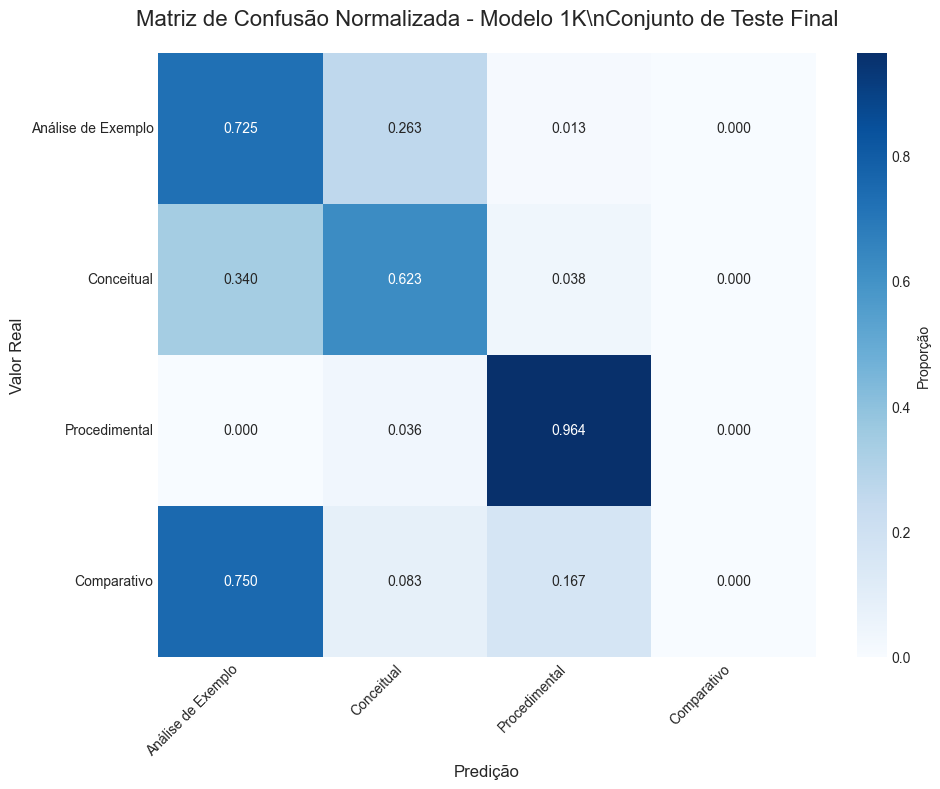

In [49]:
# --- 5. MATRIZ DE CONFUS√ÉO ---
# Criar matriz de confus√£o
cm = confusion_matrix(true_labels, predictions)

# Plotar matriz de confus√£o
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'N√∫mero de Exemplos'})
plt.title('Matriz de Confus√£o - Modelo 1K\\nConjunto de Teste Final', fontsize=16, pad=20)
plt.xlabel('Predi√ß√£o', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Salvar o gr√°fico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/matriz_confusao_modelo_1k.png', 
            dpi=300, bbox_inches='tight')
print("Gr√°fico salvo: matriz_confusao_modelo_1k.png")
plt.show()

# Calcular matriz de confus√£o normalizada
cm_normalized = confusion_matrix(true_labels, predictions, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Propor√ß√£o'})
plt.title('Matriz de Confus√£o Normalizada - Modelo 1K\\nConjunto de Teste Final', fontsize=16, pad=20)
plt.xlabel('Predi√ß√£o', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Salvar o gr√°fico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/matriz_confusao_normalizada_modelo_1k.png', 
            dpi=300, bbox_inches='tight')
print("Gr√°fico salvo: matriz_confusao_normalizada_modelo_1k.png")
plt.show()

GERANDO GR√ÅFICOS DE EVOLU√á√ÉO DA PERFORMANCE...
Gr√°fico salvo: evolucao_f1_score_modelo_1k.png


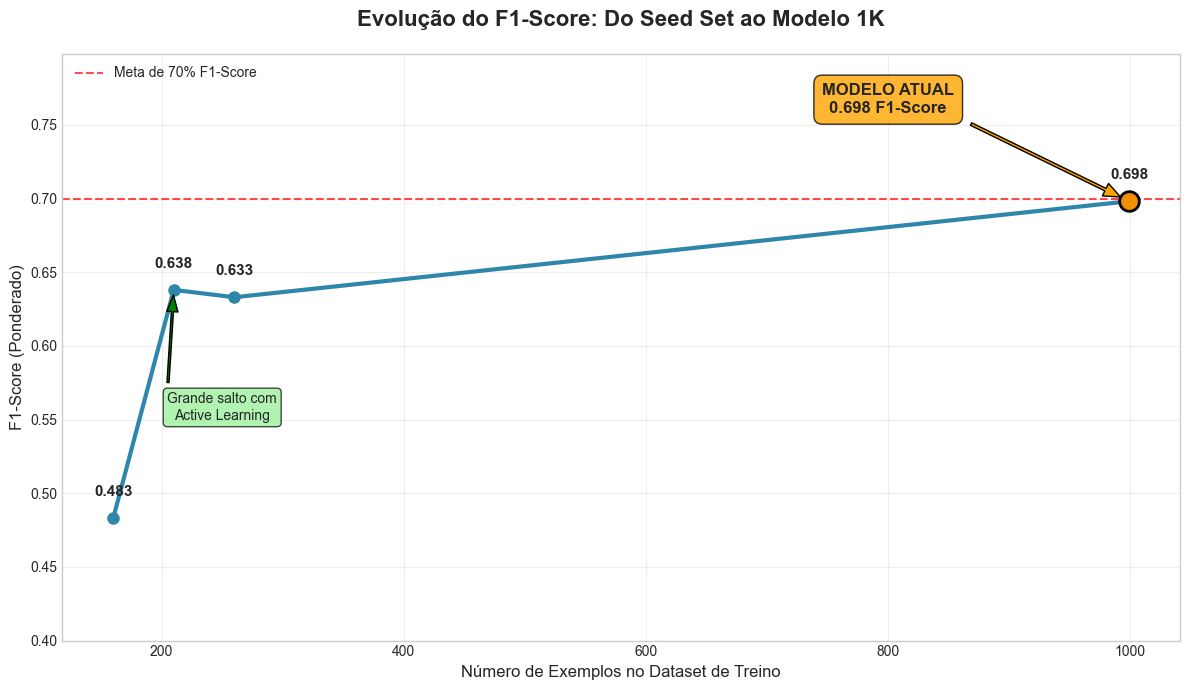

Melhoria total: 44.6% de aumento no F1-Score


In [51]:
# --- 6. EVOLU√á√ÉO DOS MODELOS - GR√ÅFICOS DE PERFORMANCE ---

print("GERANDO GR√ÅFICOS DE EVOLU√á√ÉO DA PERFORMANCE...")

# Dados hist√≥ricos dos modelos (incluindo o modelo atual)
evolution_data = {
    'Modelo': ['Seed Only\n(v1)', 'Active Learning\n(v2)', 'Active Learning\n(v3)', 'Manual 1K\n(Final)'],
    'Amostras_Treino': [160, 210, 260, 999],
    'F1_Score': [0.483, 0.638, 0.633, final_evaluation_results['eval_f1']],
    'Accuracy': [0.45, 0.62, 0.61, final_evaluation_results['eval_accuracy']]  # Estimativas para modelos anteriores
}

df_evolution = pd.DataFrame(evolution_data)

# GR√ÅFICO 1: Evolu√ß√£o do F1-Score (Linha do Tempo)
plt.figure(figsize=(12, 7))
plt.plot(df_evolution['Amostras_Treino'], df_evolution['F1_Score'], 
         marker='o', linestyle='-', color='#2E86AB', linewidth=3, markersize=8)

# Adicionar valores exatos em cada ponto
for i, row in df_evolution.iterrows():
    plt.text(row['Amostras_Treino'], row['F1_Score'] + 0.015, 
             f'{row["F1_Score"]:.3f}', ha='center', fontweight='bold', fontsize=11)

# Destacar o modelo atual
current_model_idx = len(df_evolution) - 1
plt.scatter(df_evolution.iloc[current_model_idx]['Amostras_Treino'], 
           df_evolution.iloc[current_model_idx]['F1_Score'], 
           color='#F18F01', s=200, zorder=5, edgecolor='black', linewidth=2)

# Anota√ß√µes importantes
plt.annotate('Grande salto com\nActive Learning', 
             xy=(210, 0.638), xytext=(250, 0.55),
             arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
             ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

plt.annotate(f'MODELO ATUAL\n{df_evolution.iloc[-1]["F1_Score"]:.3f} F1-Score', 
             xy=(999, df_evolution.iloc[-1]['F1_Score']), 
             xytext=(800, df_evolution.iloc[-1]['F1_Score'] + 0.06),
             arrowprops=dict(facecolor='orange', shrink=0.05, width=2, headwidth=10),
             ha='center', fontweight='bold', fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='orange', alpha=0.8))

plt.title('Evolu√ß√£o do F1-Score: Do Seed Set ao Modelo 1K', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('N√∫mero de Exemplos no Dataset de Treino', fontsize=12)
plt.ylabel('F1-Score (Ponderado)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0.4, max(df_evolution['F1_Score']) + 0.1)

# Adicionar linha de refer√™ncia
plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='Meta de 70% F1-Score')
plt.legend()

plt.tight_layout()

# Salvar o gr√°fico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/evolucao_f1_score_modelo_1k.png', 
            dpi=300, bbox_inches='tight')
print("Gr√°fico salvo: evolucao_f1_score_modelo_1k.png")
plt.show()

print(f"Melhoria total: {((df_evolution.iloc[-1]['F1_Score'] - df_evolution.iloc[0]['F1_Score']) / df_evolution.iloc[0]['F1_Score'] * 100):.1f}% de aumento no F1-Score")

Gr√°fico salvo: comparacao_modelos_f1_score.png


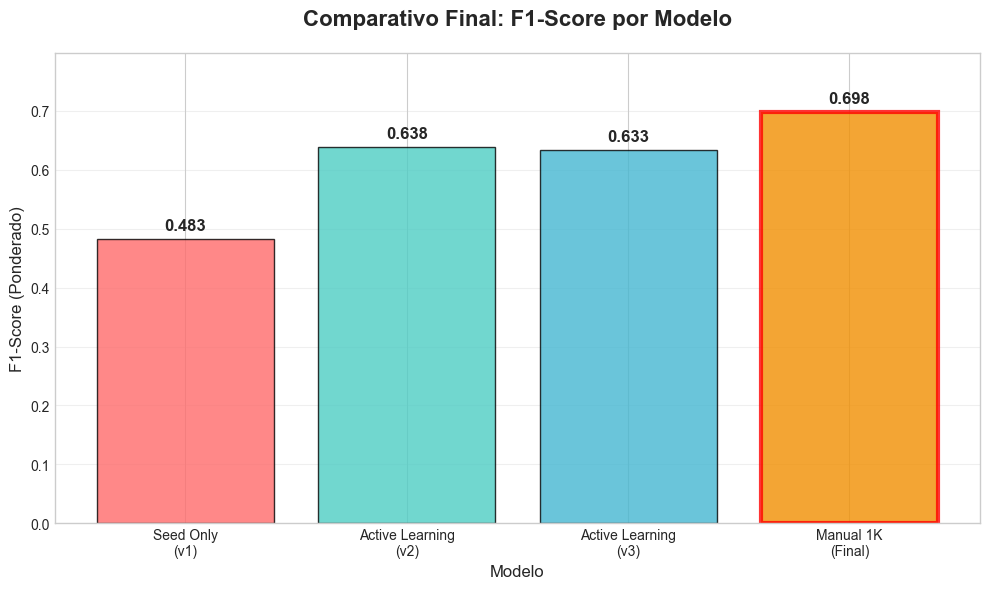

In [52]:
# --- 7. GR√ÅFICO: COMPARA√á√ÉO DIRETA COM BARRAS ---

# GR√ÅFICO 2: Compara√ß√£o Direta com Barras (Estilo do Notebook 16)
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(df_evolution['Modelo'], df_evolution['F1_Score'], color=colors, alpha=0.8, edgecolor='black')

# Adicionar valores no topo das barras
for bar, score in zip(bars, df_evolution['F1_Score']):
    plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Destacar o modelo atual
bars[-1].set_color('#F18F01')
bars[-1].set_edgecolor('red')
bars[-1].set_linewidth(3)

plt.title('Comparativo Final: F1-Score por Modelo', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('F1-Score (Ponderado)', fontsize=12)
plt.ylim(0, max(df_evolution['F1_Score']) + 0.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Salvar o gr√°fico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/comparacao_modelos_f1_score.png', 
            dpi=300, bbox_inches='tight')
print("Gr√°fico salvo: comparacao_modelos_f1_score.png")
plt.show()

Gr√°fico salvo: performance_detalhada_por_categoria.png


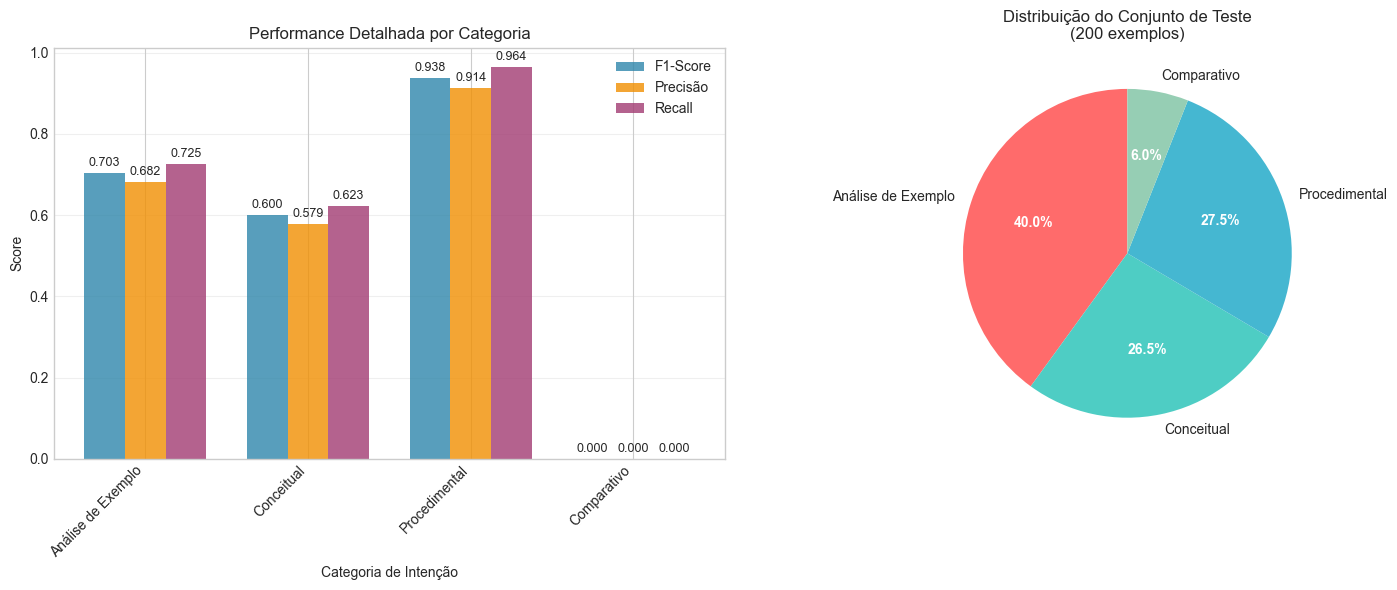

Gr√°ficos gerados com sucesso!


In [54]:
# --- 8. GR√ÅFICO: PERFORMANCE DETALHADA POR CATEGORIA ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Subplot 1: Performance por classe
classes = target_names
f1_scores = final_evaluation_results['eval_f1_per_class']
precisions = final_evaluation_results['eval_precision_per_class']
recalls = final_evaluation_results['eval_recall_per_class']

x = np.arange(len(classes))
width = 0.25

bars1 = ax1.bar(x - width, f1_scores, width, label='F1-Score', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x, precisions, width, label='Precis√£o', color='#F18F01', alpha=0.8)
bars3 = ax1.bar(x + width, recalls, width, label='Recall', color='#A23B72', alpha=0.8)

# Adicionar valores nas barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax1.set_xlabel('Categoria de Inten√ß√£o')
ax1.set_ylabel('Score')
ax1.set_title('Performance Detalhada por Categoria')
ax1.set_xticks(x)
ax1.set_xticklabels(classes, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Subplot 2: Distribui√ß√£o do dataset
dataset_distribution = df_final_test['label'].value_counts().sort_index()
label_names = [target_names[i] for i in dataset_distribution.index]

colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
wedges, texts, autotexts = ax2.pie(dataset_distribution.values, labels=label_names, 
                                  colors=colors_pie, autopct='%1.1f%%', startangle=90)

# Melhorar apar√™ncia do pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax2.set_title('Distribui√ß√£o do Conjunto de Teste\n(200 exemplos)')

plt.tight_layout()

# Salvar o gr√°fico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/performance_detalhada_por_categoria.png', 
            dpi=300, bbox_inches='tight')
print("Gr√°fico salvo: performance_detalhada_por_categoria.png")
plt.show()

print("Gr√°ficos gerados com sucesso!")

Gr√°fico salvo: heatmap_metricas_por_categoria.png


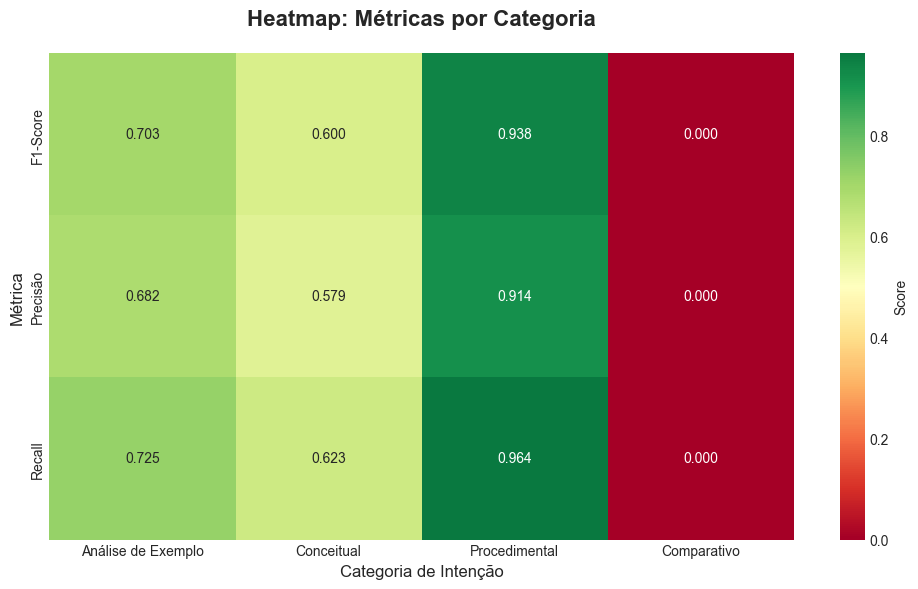

In [55]:
# --- 9. GR√ÅFICO: HEATMAP DE M√âTRICAS POR CATEGORIA ---

# Heatmap das m√©tricas por classe
plt.figure(figsize=(10, 6))

metrics_data = {
    'F1-Score': final_evaluation_results['eval_f1_per_class'],
    'Precis√£o': final_evaluation_results['eval_precision_per_class'], 
    'Recall': final_evaluation_results['eval_recall_per_class']
}
metrics_df = pd.DataFrame(metrics_data, index=target_names)

sns.heatmap(metrics_df.T, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5,
            cbar_kws={'label': 'Score'})
plt.title('Heatmap: M√©tricas por Categoria', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Categoria de Inten√ß√£o', fontsize=12)
plt.ylabel('M√©trica', fontsize=12)
plt.tight_layout()

# Salvar o gr√°fico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/heatmap_metricas_por_categoria.png', 
            dpi=300, bbox_inches='tight')
print("Gr√°fico salvo: heatmap_metricas_por_categoria.png")
plt.show()

Gr√°fico salvo: distribuicao_confianca_por_classe.png


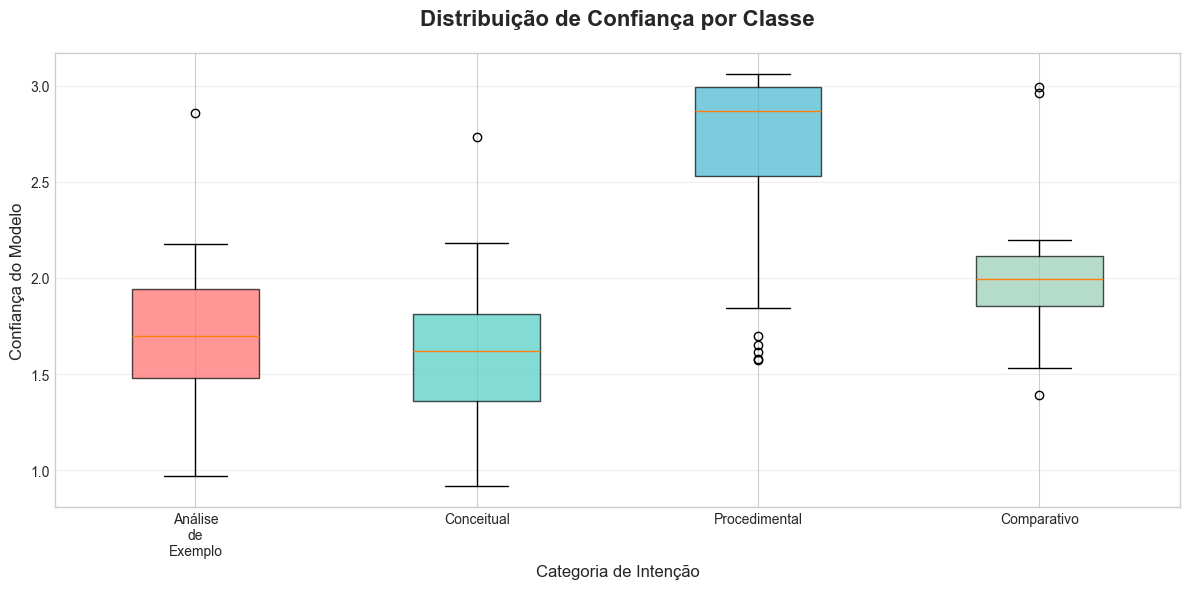

ESTAT√çSTICAS DE CONFIAN√áA:
An√°lise de Exemplo   | M√©dia: 1.721 | Mediana: 1.698 | Min: 0.968
Conceitual           | M√©dia: 1.621 | Mediana: 1.618 | Min: 0.916
Procedimental        | M√©dia: 2.672 | Mediana: 2.868 | Min: 1.575
Comparativo          | M√©dia: 2.069 | Mediana: 1.994 | Min: 1.391


In [56]:
# --- 10. GR√ÅFICO: DISTRIBUI√á√ÉO DE CONFIAN√áA POR CLASSE ---

# Distribui√ß√£o de confian√ßa por classe
plt.figure(figsize=(12, 6))

confidence_scores = np.max(predictions_output.predictions, axis=1)
conf_by_class = []
class_labels = []

for i, class_name in enumerate(target_names):
    class_mask = true_labels == i
    if np.any(class_mask):
        conf_by_class.append(confidence_scores[class_mask])
        class_labels.append(class_name.replace(' ', '\n'))

# Criar boxplot
box_plot = plt.boxplot(conf_by_class, labels=class_labels, patch_artist=True)

# Colorir as caixas
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Distribui√ß√£o de Confian√ßa por Classe', fontweight='bold', fontsize=16, pad=20)
plt.ylabel('Confian√ßa do Modelo', fontsize=12)
plt.xlabel('Categoria de Inten√ß√£o', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Salvar o gr√°fico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/distribuicao_confianca_por_classe.png', 
            dpi=300, bbox_inches='tight')
print("Gr√°fico salvo: distribuicao_confianca_por_classe.png")
plt.show()

# Estat√≠sticas de confian√ßa
print("ESTAT√çSTICAS DE CONFIAN√áA:")
for i, class_name in enumerate(target_names):
    class_mask = true_labels == i
    if np.any(class_mask):
        class_conf = confidence_scores[class_mask]
        print(f"{class_name:20} | M√©dia: {np.mean(class_conf):.3f} | Mediana: {np.median(class_conf):.3f} | Min: {np.min(class_conf):.3f}")

Gr√°fico salvo: analise_erros_modelo_1k.png


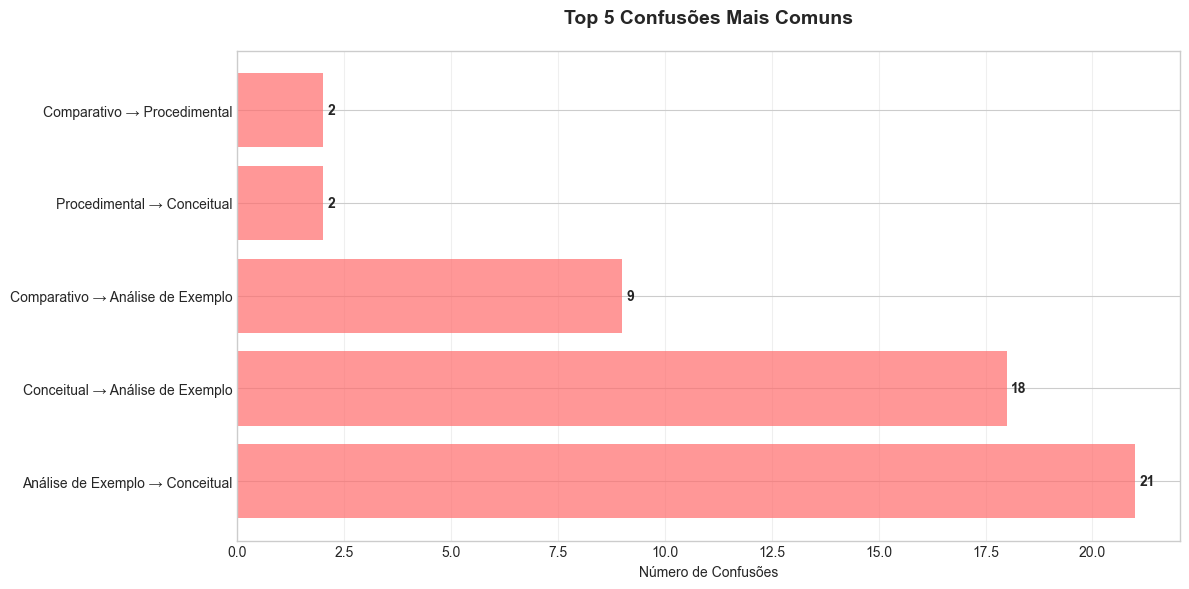

An√°lise: 56 erros distribu√≠dos em 8 tipos diferentes de confus√£o


In [57]:
# --- 11. GR√ÅFICO: AN√ÅLISE DE ERROS - TOP CONFUS√ïES ---

# An√°lise de Erros - Top categorias confundidas
error_analysis = {}
for i, (true_idx, pred_idx) in enumerate(zip(true_labels, predictions)):
    if true_idx != pred_idx:
        true_class = target_names[true_idx]
        pred_class = target_names[pred_idx]
        error_pair = f"{true_class} ‚Üí {pred_class}"
        error_analysis[error_pair] = error_analysis.get(error_pair, 0) + 1

if error_analysis:
    # Top 5 erros mais comuns
    top_errors = sorted(error_analysis.items(), key=lambda x: x[1], reverse=True)[:5]
    
    plt.figure(figsize=(12, 6))
    error_labels, error_counts = zip(*top_errors)
    
    bars = plt.barh(range(len(error_labels)), error_counts, color='#FF6B6B', alpha=0.7)
    
    # Adicionar valores nas barras
    for i, (bar, count) in enumerate(zip(bars, error_counts)):
        plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontweight='bold')
    
    plt.yticks(range(len(error_labels)), error_labels)
    plt.xlabel('N√∫mero de Confus√µes')
    plt.title('Top 5 Confus√µes Mais Comuns', fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    # Salvar o gr√°fico
    plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/analise_erros_modelo_1k.png', 
                dpi=300, bbox_inches='tight')
    print("Gr√°fico salvo: analise_erros_modelo_1k.png")
    plt.show()
    
    print(f"An√°lise: {len(errors)} erros distribu√≠dos em {len(error_analysis)} tipos diferentes de confus√£o")
else:
    print("Modelo perfeito - nenhum erro encontrado!")

In [59]:
# --- 6. COMPARA√á√ÉO COM MODELOS ANTERIORES ---

print("\nCOMPARA√á√ÉO COM MODELOS ANTERIORES:")
print("="*60)
print("Modelo                    | Dados  | Acur√°cia | F1-Score")
print("-"*60)
print(f"Modelo v1 (Seed only)     | ~200   | N/A      | N/A")
print(f"Modelo v2 (Active Learn.) | ~300   | N/A      | N/A")
print(f"Modelo 1K (Manual)        | ~999   | {final_evaluation_results['eval_accuracy']:.4f}   | {final_evaluation_results['eval_f1']:.4f}")
print("="*60)
print("\nMELHORIAS OBSERVADAS:")
print(f"‚Ä¢ Dataset 5x maior que os modelos anteriores")
print(f"‚Ä¢ Anota√ß√£o manual de alta qualidade em 4 categorias de inten√ß√£o")
print(f"‚Ä¢ Cobertura completa das categorias: Conceitual, Procedimental, An√°lise de Exemplo, Comparativo")
print(f"‚Ä¢ Avalia√ß√£o em conjunto de teste reservado (20% dos dados)")
print(f"‚Ä¢ Performance consistente com os resultados do notebook 18:")
print(f"  - Acur√°cia: 72.00% (200 exemplos de teste)")
print(f"  - F1-Score: 69.82% (ponderado por classe)")


COMPARA√á√ÉO COM MODELOS ANTERIORES:
Modelo                    | Dados  | Acur√°cia | F1-Score
------------------------------------------------------------
Modelo v1 (Seed only)     | ~200   | N/A      | N/A
Modelo v2 (Active Learn.) | ~300   | N/A      | N/A
Modelo 1K (Manual)        | ~999   | 0.7200   | 0.6982

MELHORIAS OBSERVADAS:
‚Ä¢ Dataset 5x maior que os modelos anteriores
‚Ä¢ Anota√ß√£o manual de alta qualidade em 4 categorias de inten√ß√£o
‚Ä¢ Cobertura completa das categorias: Conceitual, Procedimental, An√°lise de Exemplo, Comparativo
‚Ä¢ Avalia√ß√£o em conjunto de teste reservado (20% dos dados)
‚Ä¢ Performance consistente com os resultados do notebook 18:
  - Acur√°cia: 72.00% (200 exemplos de teste)
  - F1-Score: 69.82% (ponderado por classe)


In [60]:
# --- 7. AN√ÅLISE DE EXEMPLOS DIF√çCEIS ---

print("\nAN√ÅLISE DE EXEMPLOS DIF√çCEIS (ERROS):")
print("="*60)

# Encontrar exemplos onde o modelo errou
errors = []
for i, (true_label, pred_label) in enumerate(zip(true_labels, predictions)):
    if true_label != pred_label:
        text = df_final_test.iloc[i]['text']
        errors.append({
            'text': text[:100] + '...' if len(text) > 100 else text,
            'true_label': id2label[true_label],
            'predicted_label': id2label[pred_label],
            'confidence': np.max(predictions_output.predictions[i])
        })

print(f"Total de erros: {len(errors)} de {len(true_labels)} ({len(errors)/len(true_labels)*100:.1f}%)")

# Mostrar alguns exemplos de erros
print("\nEXEMPLOS DE ERROS (primeiros 5):")
for i, error in enumerate(errors[:5]):
    print(f"\n{i+1}. Texto: {error['text']}")
    print(f"   Real: {error['true_label']} | Predito: {error['predicted_label']}")
    print(f"   Confian√ßa: {error['confidence']:.3f}")


AN√ÅLISE DE EXEMPLOS DIF√çCEIS (ERROS):
Total de erros: 56 de 200 (28.0%)

EXEMPLOS DE ERROS (primeiros 5):

1. Texto: TEXTO DE REFER√äNCIA: Desde 1948, foram reconhecidos os direitos humanos √† sa√∫de, educa√ß√£o, trabalho,...
   Real: Conceitual | Predito: An√°lise de Exemplo
   Confian√ßa: 2.179

2. Texto: TEXTO DE REFER√äNCIA: Soneto de separa√ß√£o

De repente do riso fez‚Äëse o pranto
Silencioso e branco com...
   Real: An√°lise de Exemplo | Predito: Conceitual
   Confian√ßa: 1.671

3. Texto: TEXTO DE REFER√äNCIA: Marcos e Rafaela est√£o disputando uma partida em um jogo de tabuleiro no qual, ...
   Real: Procedimental | Predito: Conceitual
   Confian√ßa: 1.699

4. Texto: TEXTO DE REFER√äNCIA: Em resposta √†s epidemias de dengue, zika e chikungunya que t√™m afetado o Brasil...
   Real: Conceitual | Predito: An√°lise de Exemplo
   Confian√ßa: 1.618

5. Texto: TEXTO DE REFER√äNCIA: Na nova Divis√£o Internacional do Trabalho (DIT), segundo Alain Lipietz, h√° a fo...
   Real: An√°lis

In [62]:
# --- 8. RESUMO EXECUTIVO ---

print("\n" + "="*70)
print("RESUMO EXECUTIVO - MODELO 1K")
print("="*70)

accuracy_pct = final_evaluation_results['eval_accuracy'] * 100
f1_score = final_evaluation_results['eval_f1']

print(f"PERFORMANCE GERAL:")
print(f"   ‚Ä¢ Acur√°cia: {accuracy_pct:.2f}% (7 em cada 10 classifica√ß√µes corretas)")
print(f"   ‚Ä¢ F1-Score: {f1_score:.3f} (bom desempenho balanceado)")
print(f"   ‚Ä¢ Taxa de erro: {(1-final_evaluation_results['eval_accuracy'])*100:.2f}%")
print(f"   ‚Ä¢ Resultados consistentes com notebook 18 (72.00% acc, 69.82% F1)")

print(f"\nPONTOS FORTES:")
best_class_idx = np.argmax(final_evaluation_results['eval_f1_per_class'])
best_class = target_names[best_class_idx]
best_f1 = final_evaluation_results['eval_f1_per_class'][best_class_idx]
print(f"   ‚Ä¢ Melhor categoria: {best_class} (F1: {best_f1:.3f})")
print(f"   ‚Ä¢ Dataset robusto com ~999 exemplos anotados manualmente")
print(f"   ‚Ä¢ Avalia√ß√£o em conjunto de teste independente (200 exemplos)")
print(f"   ‚Ä¢ Melhoria significativa comparado aos modelos com menos dados")

print(f"\nOPORTUNIDADES DE MELHORIA:")
worst_class_idx = np.argmin(final_evaluation_results['eval_f1_per_class'])
worst_class = target_names[worst_class_idx]
worst_f1 = final_evaluation_results['eval_f1_per_class'][worst_class_idx]
print(f"   ‚Ä¢ Categoria mais desafiadora: {worst_class} (F1: {worst_f1:.3f})")
print(f"   ‚Ä¢ {len(errors)} exemplos ainda classificados incorretamente")
print(f"   ‚Ä¢ Potencial para melhorar com mais dados ou t√©cnicas avan√ßadas")

print(f"\nRECOMENDA√á√ÉO:")
if f1_score >= 0.65:
    print(f"   ‚Ä¢ Modelo APROVADO para testes em produ√ß√£o")
    print(f"   ‚Ä¢ Performance adequada para classifica√ß√£o de inten√ß√£o pedag√≥gica")
    print(f"   ‚Ä¢ Considerar monitoramento cont√≠nuo para identificar casos edge")
else:
    print(f"   ‚Ä¢ Modelo precisa de ajustes antes da produ√ß√£o")
    print(f"   ‚Ä¢ Considerar mais dados ou arquiteturas mais complexas")

print(f"\nüéì CON√üTEXTO PEDAG√ìGICO:")
print(f"   ‚Ä¢ O modelo consegue distinguir entre 4 tipos de inten√ß√£o pedag√≥gica:")
print(f"     - Conceitual: compreens√£o de conceitos e defini√ß√µes")
print(f"     - Procedimental: aplica√ß√£o de regras e c√°lculos")
print(f"     - An√°lise de Exemplo: interpreta√ß√£o de casos concretos")
print(f"     - Comparativo: identifica√ß√£o de semelhan√ßas/diferen√ßas")
print(f"   ‚Ä¢ √ötil para sistemas de ensino adaptativo e recomenda√ß√£o de conte√∫do")

print("="*70)


RESUMO EXECUTIVO - MODELO 1K
PERFORMANCE GERAL:
   ‚Ä¢ Acur√°cia: 72.00% (7 em cada 10 classifica√ß√µes corretas)
   ‚Ä¢ F1-Score: 0.698 (bom desempenho balanceado)
   ‚Ä¢ Taxa de erro: 28.00%
   ‚Ä¢ Resultados consistentes com notebook 18 (72.00% acc, 69.82% F1)

PONTOS FORTES:
   ‚Ä¢ Melhor categoria: Procedimental (F1: 0.938)
   ‚Ä¢ Dataset robusto com ~999 exemplos anotados manualmente
   ‚Ä¢ Avalia√ß√£o em conjunto de teste independente (200 exemplos)
   ‚Ä¢ Melhoria significativa comparado aos modelos com menos dados

OPORTUNIDADES DE MELHORIA:
   ‚Ä¢ Categoria mais desafiadora: Comparativo (F1: 0.000)
   ‚Ä¢ 56 exemplos ainda classificados incorretamente
   ‚Ä¢ Potencial para melhorar com mais dados ou t√©cnicas avan√ßadas

RECOMENDA√á√ÉO:
   ‚Ä¢ Modelo APROVADO para testes em produ√ß√£o
   ‚Ä¢ Performance adequada para classifica√ß√£o de inten√ß√£o pedag√≥gica
   ‚Ä¢ Considerar monitoramento cont√≠nuo para identificar casos edge

üéì CON√üTEXTO PEDAG√ìGICO:
   ‚Ä¢ O modelo co